In [96]:
from glob import glob
import json
import pydicom
import pickle
import pandas as pd
import matplotlib.pylab as plt

DICOM_TAGS_DF_PATH = '/kolos/m2/ct/data/rsna/df.pkl'
LABELS_PATH = '/kolos/storage/ct/data/rsna/stage_1_train.csv'

In [18]:
def load_dicom_tags():
    with open(DICOM_TAGS_DF_PATH, 'rb') as f:
        df = pickle.load(f)

    return df

def load_labels():
    labels = pd.read_csv(LABELS_PATH)
    labels[['SOPInstanceUID', 'Disease']] = labels.ID.str.rsplit("_", 1, expand=True)
    labels = labels[['SOPInstanceUID', 'Disease', 'Label']]
    labels = pd.pivot_table(labels, index="SOPInstanceUID", columns="Disease", values="Label")
    
    return labels


tags = load_dicom_tags()
labels = load_labels()

df = labels.merge(tags, on='SOPInstanceUID', how='outer')

# Columns with constant values

In [100]:
names = {}
for column in df.columns:
    try:
        unique_values = df[column].unique()
        if len(unique_values) == 1:
            names[column] = unique_values[0]
    except:
        pass

df = df.drop(columns=names.keys())
print(names)

{'Modality': 'CT', 'StudyID': '', 'SamplesPerPixel': 1, 'PhotometricInterpretation': 'MONOCHROME2', 'BitsAllocated': 16, 'RescaleSlope': 1.0}


In [101]:
df.head()

,SOPInstanceUID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,PatientID,StudyInstanceUID,SeriesInstanceUID,...,Columns,PixelSpacing,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,path,subset
0,ID_000039fa0,0.0,0.0,0.0,0.0,0.0,0.0,ID_eeaf99e7,ID_134d398b61,ID_5f8484c3e0,...,512,"[0.488281, 0.488281]",16,15,1,30,80,-1024.0,/kolos/storage/ct/data/rsna/stage_1_train_imag...,train
1,ID_00005679d,0.0,0.0,0.0,0.0,0.0,0.0,ID_18f2d431,ID_b5c26cda09,ID_203cd6ec46,...,512,"[0.460938, 0.460938]",16,15,1,50,100,-1024.0,/kolos/storage/ct/data/rsna/stage_1_train_imag...,train
2,ID_00008ce3c,0.0,0.0,0.0,0.0,0.0,0.0,ID_ce8a3cd2,ID_974735bf79,ID_3780d48b28,...,512,"[0.48828125, 0.48828125]",12,11,0,"[00040, 00040]","[00080, 00080]",-1024.0,/kolos/storage/ct/data/rsna/stage_1_train_imag...,train
3,ID_0000950d7,0.0,0.0,0.0,0.0,0.0,0.0,ID_d278c67b,ID_8881b1c4b1,ID_84296c3845,...,512,"[0.494863, 0.494863]",16,15,1,35,135,-1024.0,/kolos/storage/ct/data/rsna/stage_1_train_imag...,train
4,ID_0000aee4b,0.0,0.0,0.0,0.0,0.0,0.0,ID_ce5f0b6c,ID_9aad90e421,ID_1e59488a44,...,512,"[0.423828125, 0.423828125]",12,11,0,"[00036, 00036]","[00080, 00080]",-1024.0,/kolos/storage/ct/data/rsna/stage_1_train_imag...,train


In [102]:
df.columns

Index(['SOPInstanceUID', 'any', 'epidural', 'intraparenchymal',
       'intraventricular', 'subarachnoid', 'subdural', 'PatientID',
       'StudyInstanceUID', 'SeriesInstanceUID', 'ImagePositionPatient',
       'ImageOrientationPatient', 'Rows', 'Columns', 'PixelSpacing',
       'BitsStored', 'HighBit', 'PixelRepresentation', 'WindowCenter',
       'WindowWidth', 'RescaleIntercept', 'path', 'subset'],
      dtype='object')

# Split proportions:

In [63]:
scans_num = len(df.groupby(['SeriesInstanceUID']))
scans_train_num = len(df[df.subset == "train"].groupby(['SeriesInstanceUID']))
scans_test_num = len(df[df.subset == "test"].groupby(['SeriesInstanceUID']))

print("Total number of scans: {} (train/test: {}/{}, {:.3f}/{:.3f})".format(
    scans_num, scans_train_num, scans_test_num, 
    scans_train_num / scans_num,
    scans_test_num / scans_num
))

slices_num = len(df)
slices_train_num =  len(df[df.subset == "train"])
slices_test_num =  len(df[df.subset == "test"])

print("Total number of slices: {} (train/test: {}/{}, {:.3f}/{:.3f})".format(
    slices_num, slices_train_num, slices_test_num,
    slices_train_num / slices_num, 
    slices_test_num / slices_num
))


Total number of scans: 21744 (train/test: 19530/2214, 0.898/0.102)
Total number of slices: 752803 (train/test: 674258/78545, 0.896/0.104)


The distribution of slices between scans for training split and test split is similar.

# Positive samples for full scans

Total number of scans: 19530


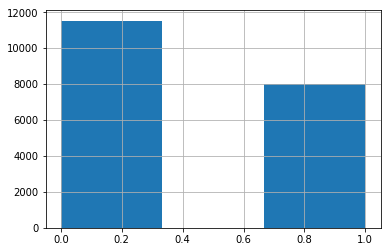

In [49]:
series = df[df.subset == "train"].groupby(['SeriesInstanceUID']).agg({"any": "sum"})
series['is_positive'] = (series["any"] > 0).astype('int32')

series.is_positive.hist(bins=3)


# Positive samples for slices

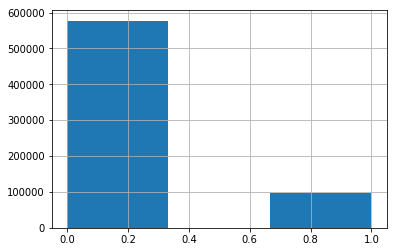

In [51]:
df[df.subset == "train"]["any"].hist(bins=3)

# Outliers

### Variable size

In [4]:
df.Rows.unique()

array([512, 464, 462, 638, 408, 768, 436, 430, 666])

In [5]:
df.Columns.unique()

array([512, 464, 462, 490, 374, 768, 436, 404])

# PixelSpacing

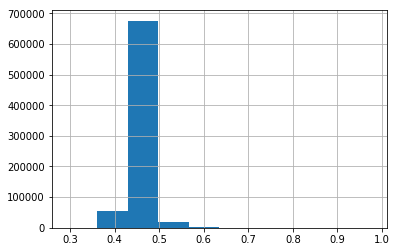

In [73]:
spacing = pd.DataFrame(df.PixelSpacing.values.tolist(), columns=['x','y'])
len(spacing[spacing.x != spacing.y])
spacing.x.hist()